In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import timm
from torchmetrics.classification import MulticlassAccuracy

In [47]:
DATASET_PATH = "/content/drive/MyDrive/dataset_nsfw_lite"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_CLASSES = 5
EPOCHS = 30
LR = 3e-4

In [17]:
!pip install -q pytorch-lightning timm torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.3/857.3 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 52.2 MB/s eta 0:00:00


In [48]:
train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.85, 1.0)),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# ================= DATA =================
full_ds = datasets.ImageFolder(DATASET_PATH, transform=train_tf)

val_size = int(0.2 * len(full_ds))
train_size = len(full_ds) - val_size

train_ds, val_ds = torch.utils.data.random_split(full_ds, [train_size, val_size])

# override transform for val
val_ds.dataset.transform = val_tf

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [53]:
class DeiTTinyLightning(pl.LightningModule):
    def __init__(self, num_classes=5, lr=3e-4):
        super().__init__()
        self.save_hyperparameters()

        # DeiT-Tiny pretrained
        self.model = timm.create_model(
            'deit_tiny_patch16_224',
            pretrained=True,
            num_classes=num_classes
        )

        self.criterion = nn.CrossEntropyLoss()
        self.acc = MulticlassAccuracy(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.acc(logits.softmax(dim=-1), y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        acc = self.acc(logits.softmax(dim=-1), y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
        return [optimizer], [scheduler]

# ================= TRAINER =================
model = DeiTTinyLightning(num_classes=NUM_CLASSES, lr=LR)

In [54]:
assert len(train_ds) > 0, "Train dataset kosong!"
assert len(val_ds) > 0, "Val dataset kosong!"
assert len(train_loader) > 0, "Train loader kosong!"
assert len(val_loader) > 0, "Val loader kosong!"

In [56]:
print(len(train_ds), len(val_ds))
print(len(train_loader), len(val_loader))
print(os.listdir(DATASET_PATH))

1200 300
75 19
['sexy', 'hentai', 'drawing', 'neutral', 'porn']


In [55]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=6, mode="min"),
    ModelCheckpoint(monitor="val_loss", save_top_k=1, mode="min", filename="deit-tiny-{epoch:02d}-{val_loss:.3f}")
]

In [57]:
print("=== BEFORE FIT ===")
trainer.fit(model, train_loader, val_loader)
print("=== AFTER FIT ===")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


=== BEFORE FIT ===


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ VisionTransformer  │  5.5 M │ train │     0 │
│ 1 │ criterion │ CrossEntropyLoss   │      0 │ train │     0 │
│ 2 │ acc       │ MulticlassAccuracy │      0 │ train │     0 │
└───┴───────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 5.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.5 M                                                                                                
Total estimated model params size (MB): 22                                                                         
Modules in train mode: 278                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

=== AFTER FIT ===


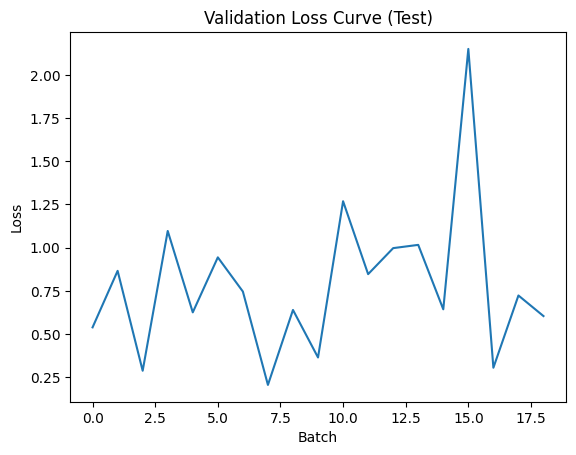

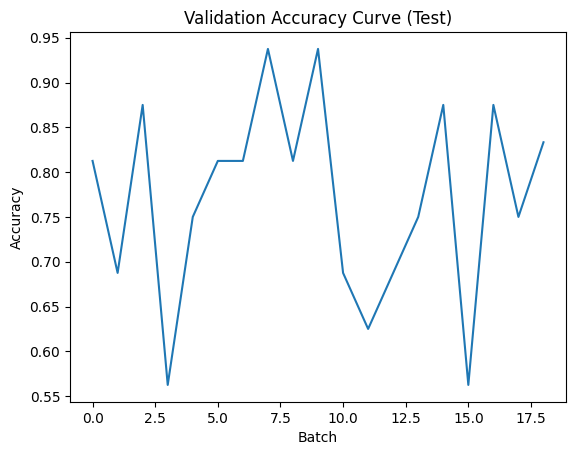

In [58]:
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()

val_losses = []
val_accs = []

correct = 0
total = 0
criterion = torch.nn.CrossEntropyLoss()

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(model.device)
        y = y.to(model.device)

        logits = model(x)
        loss = criterion(logits, y)

        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean().item()

        val_losses.append(loss.item())
        val_accs.append(acc)

# Plot Loss
plt.figure()
plt.plot(val_losses)
plt.title("Validation Loss Curve (Test)")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.show()

# Plot Accuracy
plt.figure()
plt.plot(val_accs)
plt.title("Validation Accuracy Curve (Test)")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.show()

<Figure size 700x700 with 0 Axes>

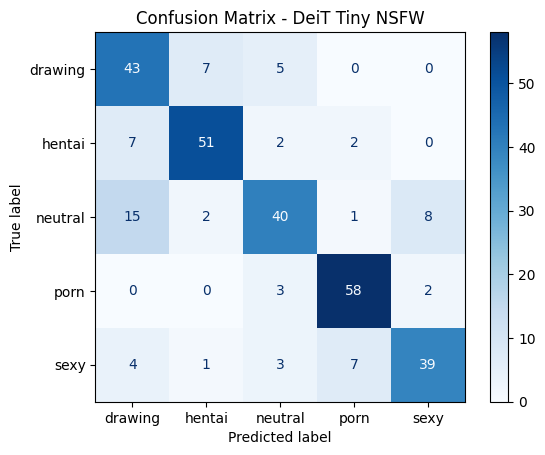

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(model.device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=full_ds.classes  # class names
)

plt.figure(figsize=(7,7))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - DeiT Tiny NSFW")
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix
import pandas as pd

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(model.device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

cm = confusion_matrix(all_labels, all_preds)

# Convert to DataFrame
cm_df = pd.DataFrame(
    cm,
    index=full_ds.classes,
    columns=full_ds.classes
)

print("Confusion Matrix (Text Table):")
print(cm_df)

Confusion Matrix (Text Table):
         drawing  hentai  neutral  porn  sexy
drawing       43       7        5     0     0
hentai         7      51        2     2     0
neutral       15       2       40     1     8
porn           0       0        3    58     2
sexy           4       1        3     7    39


In [63]:
from sklearn.metrics import accuracy_score

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(model.device)
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y.numpy())

acc = accuracy_score(all_labels, all_preds) * 100
print(f"Test Accuracy : {acc:.2f}%")

Test Accuracy : 77.00%


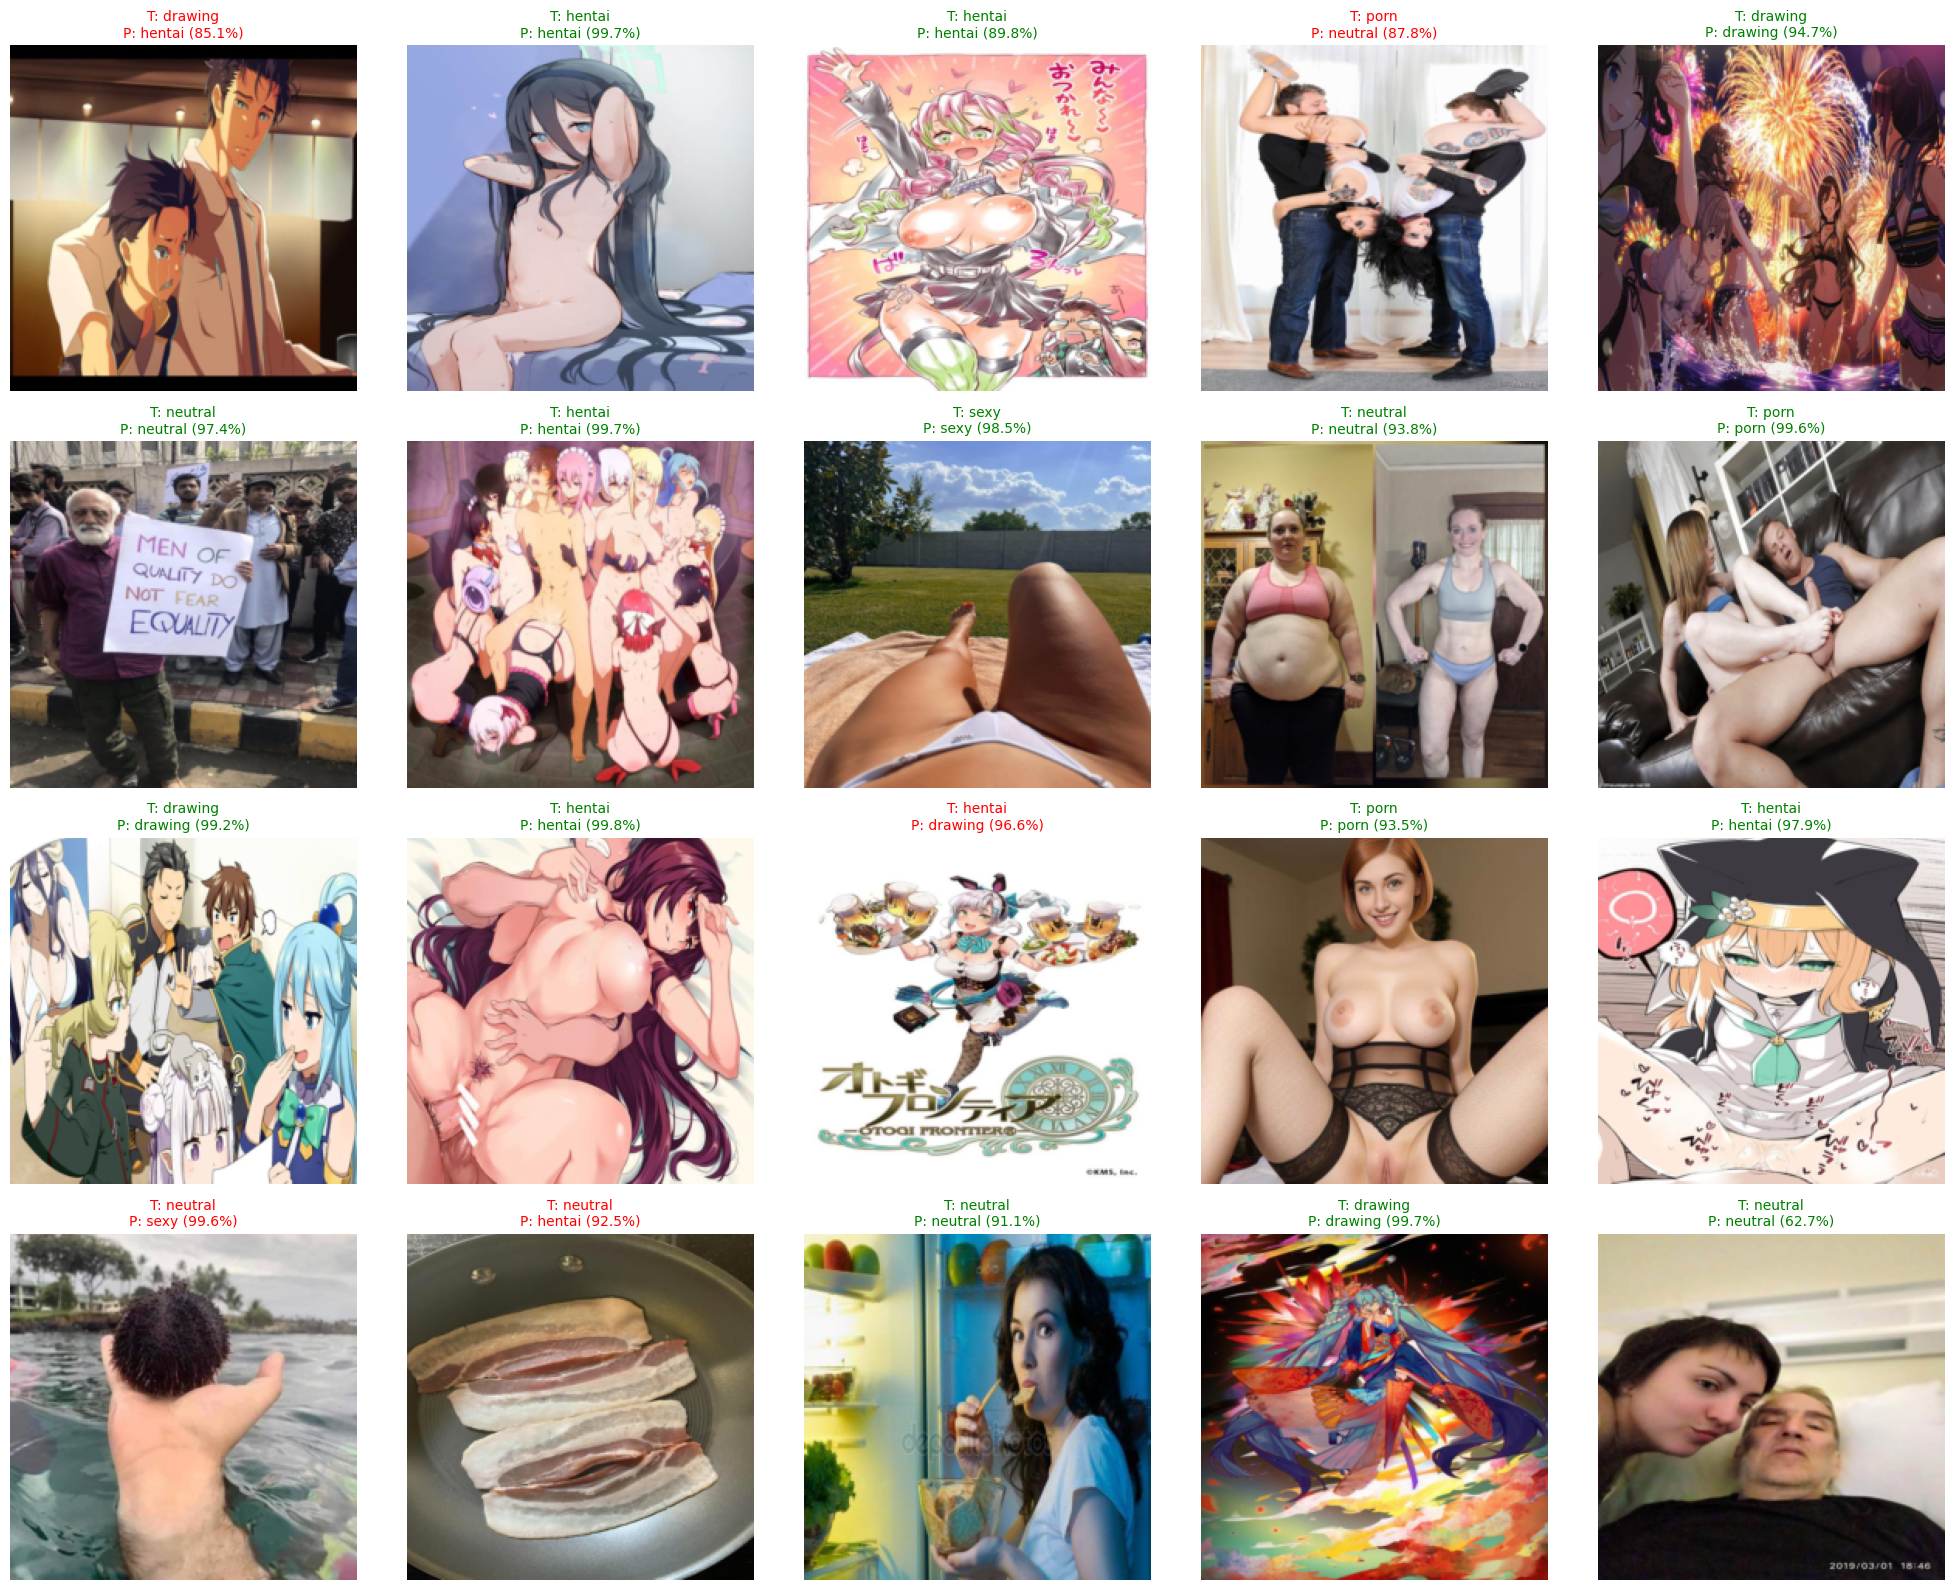

In [67]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()
model.to("cuda")

# ===== dataset =====
dataset = val_ds   # atau test_ds

# FIX DI SINI 👇
if hasattr(dataset, "dataset"):   # kalau Subset
    class_names = dataset.dataset.classes
else:
    class_names = dataset.classes

# ===== random sample =====
indices = random.sample(range(len(dataset)), 20)

images = []
labels = []
preds = []
confs = []

with torch.no_grad():
    for idx in indices:
        img, label = dataset[idx]
        inp = img.unsqueeze(0).cuda()

        logits = model(inp)
        probs = torch.softmax(logits, dim=1)

        pred = torch.argmax(probs, dim=1).item()
        conf = torch.max(probs).item()

        images.append(img)
        labels.append(label)
        preds.append(pred)
        confs.append(conf)

# ===== denormalize =====
def denorm(img):
    img = img.cpu().numpy().transpose(1,2,0)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# ===== plot =====
plt.figure(figsize=(20, 16))

for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(denorm(images[i]))
    true_lbl = class_names[labels[i]]
    pred_lbl = class_names[preds[i]]
    conf_pct = confs[i]*100

    color = "green" if true_lbl == pred_lbl else "red"

    plt.title(
        f"T: {true_lbl}\nP: {pred_lbl} ({conf_pct:.1f}%)",
        fontsize=10,
        color=color
    )
    plt.axis("off")

plt.tight_layout()
plt.show()

Total neutral+porn samples: 129


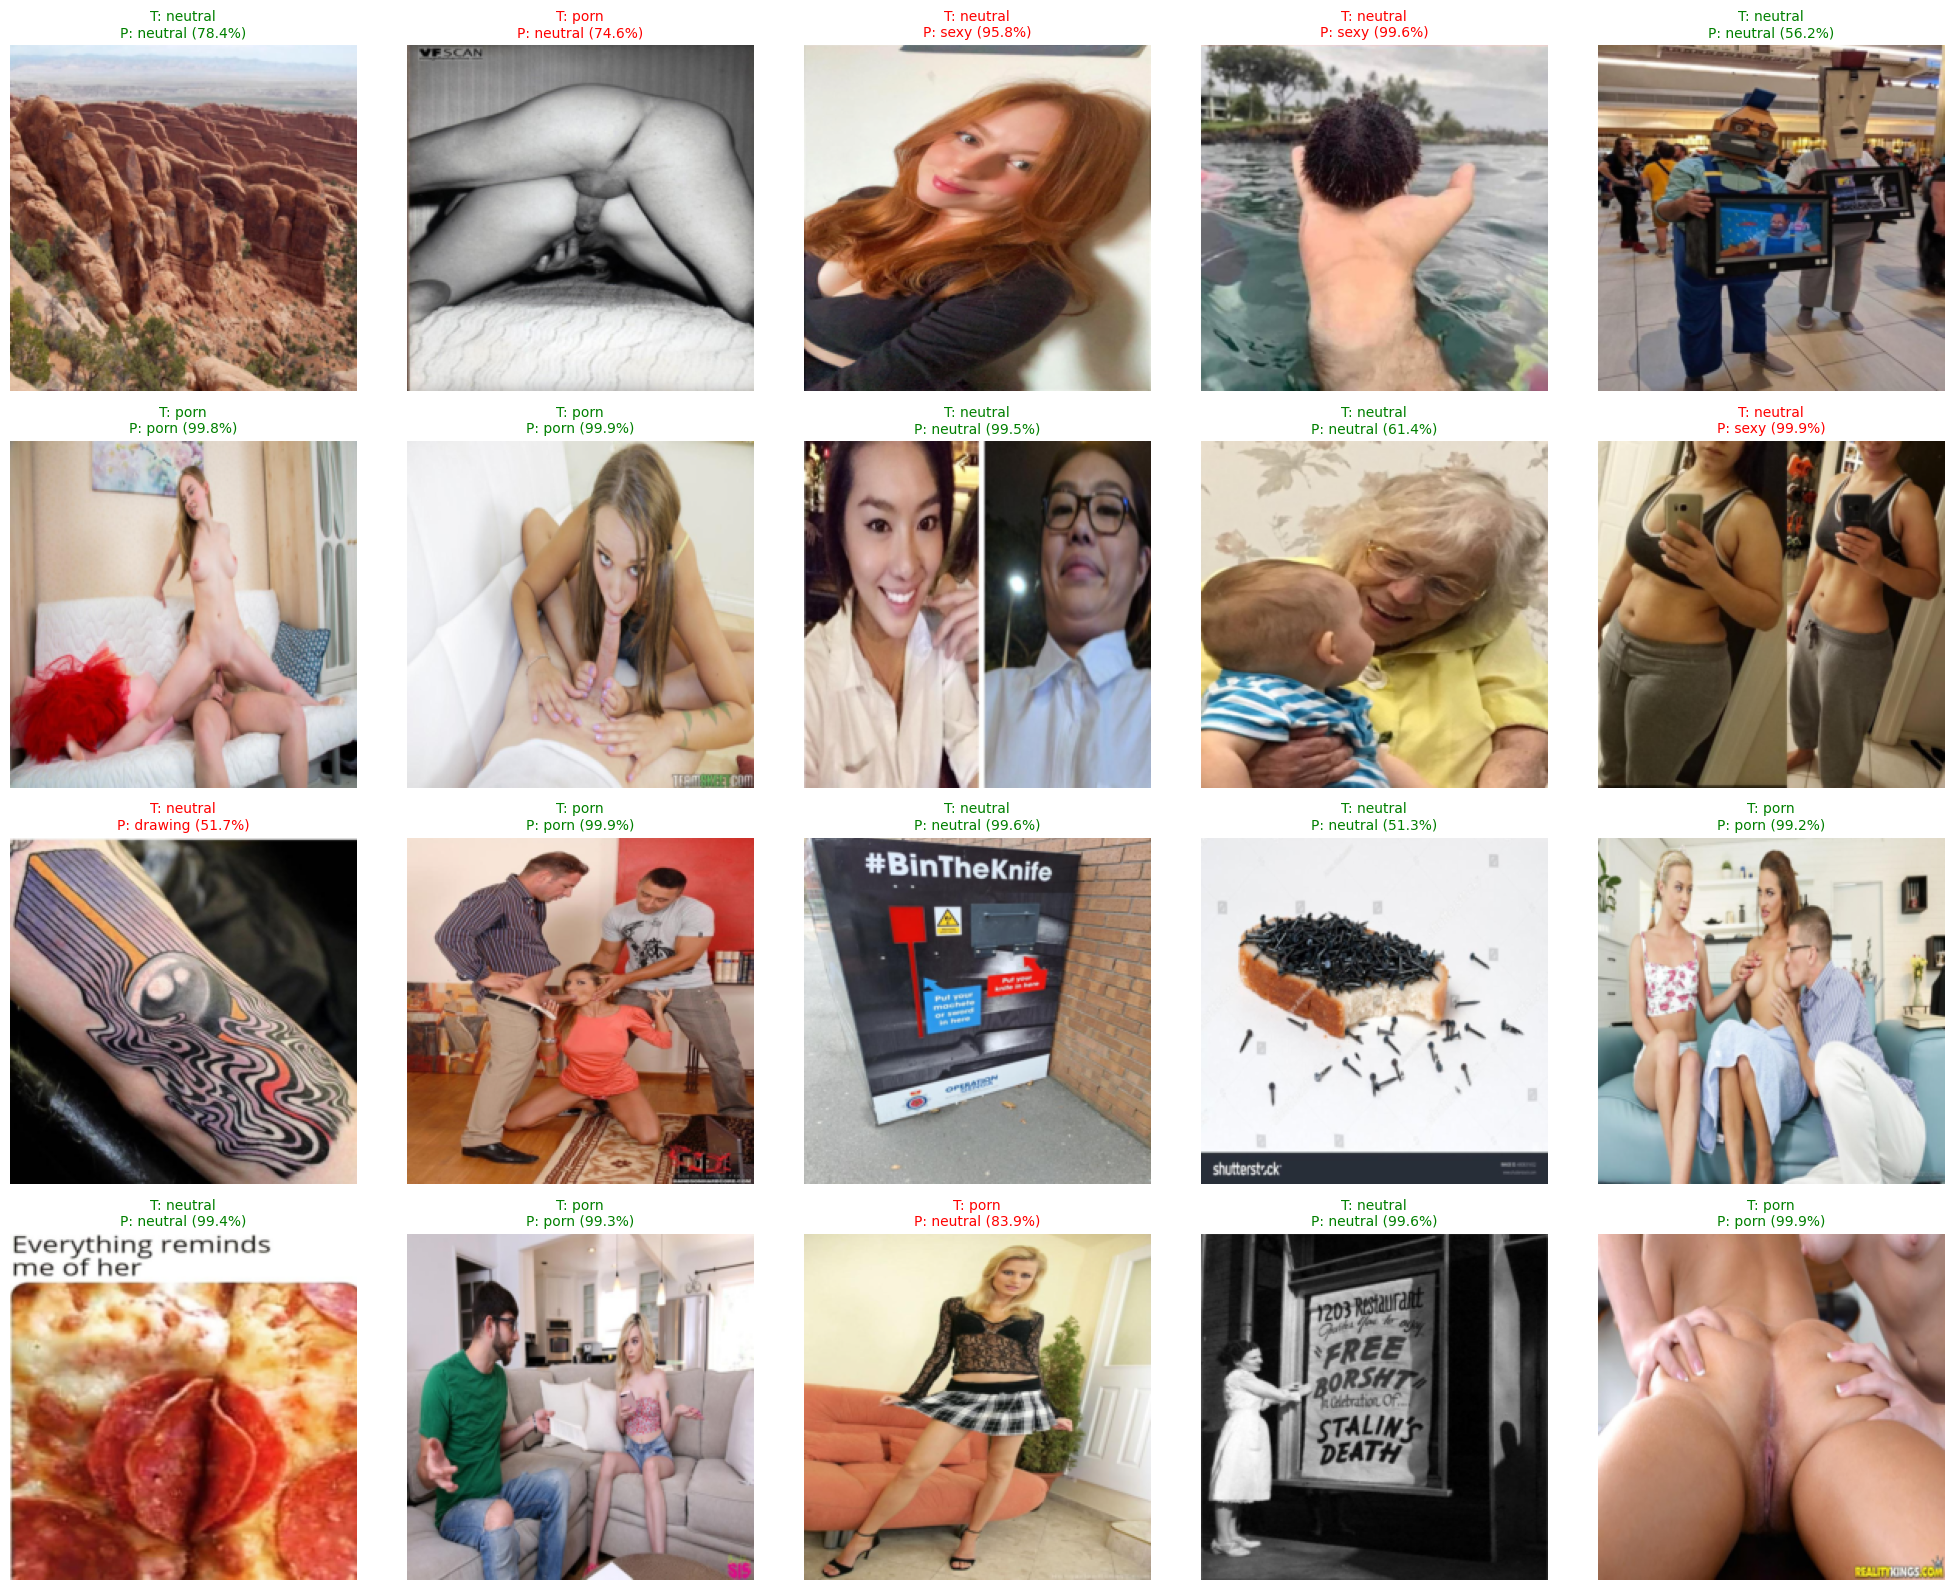

In [68]:
import random
import torch
import matplotlib.pyplot as plt
import numpy as np

model.eval()
model.to("cuda")

# ===== dataset =====
dataset = val_ds   # atau test_ds

# ambil class names (handle Subset)
if hasattr(dataset, "dataset"):
    class_names = dataset.dataset.classes
else:
    class_names = dataset.classes

# cari index class
neutral_idx = class_names.index("neutral")
porn_idx    = class_names.index("porn")

# ===== filter dataset: hanya neutral & porn =====
filtered_indices = []
for i in range(len(dataset)):
    _, label = dataset[i]
    if label in [neutral_idx, porn_idx]:
        filtered_indices.append(i)

print("Total neutral+porn samples:", len(filtered_indices))

# ===== random sample 20 =====
sample_indices = random.sample(filtered_indices, min(20, len(filtered_indices)))

images = []
labels = []
preds = []
confs = []

with torch.no_grad():
    for idx in sample_indices:
        img, label = dataset[idx]
        inp = img.unsqueeze(0).cuda()

        logits = model(inp)
        probs = torch.softmax(logits, dim=1)

        pred = torch.argmax(probs, dim=1).item()
        conf = torch.max(probs).item()

        images.append(img)
        labels.append(label)
        preds.append(pred)
        confs.append(conf)

# ===== denormalize =====
def denorm(img):
    img = img.cpu().numpy().transpose(1,2,0)
    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

# ===== plot =====
plt.figure(figsize=(20, 16))

for i in range(len(images)):
    plt.subplot(4, 5, i+1)
    plt.imshow(denorm(images[i]))

    true_lbl = class_names[labels[i]]
    pred_lbl = class_names[preds[i]]
    conf_pct = confs[i]*100

    color = "green" if true_lbl == pred_lbl else "red"

    plt.title(
        f"T: {true_lbl}\nP: {pred_lbl} ({conf_pct:.1f}%)",
        fontsize=10,
        color=color
    )
    plt.axis("off")

plt.tight_layout()
plt.show()